###  Introduction : Prédiction du Prix de Clôture Boursier

Ce projet a pour objectif de prédire le **prix de clôture des actions boursières** à l’aide de plusieurs techniques de **Machine Learning** et de **Deep Learning**.  
Nous allons utiliser les données de l’action **AAPL (Apple Inc.)** sur la période de **2010 à aujourd’hui**.

Les étapes principales du projet sont :
- Collecte des données financières via l’API `yfinance`
- Prétraitement et enrichissement des données
- Création de nouvelles variables techniques (features)
- Entraînement de modèles de régression
- Évaluation des performances
- Visualisation et interprétation des résultats

---



In [ ]:
# Prédiction du Prix de Clôture Boursier - Projet Complet
# ========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# Configuration
SYMBOLS = ['AAPL'] # Actions à analyser
START_DATE = '2010-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')
RANDOM_STATE = 42

print(" Projet de Prédiction des Prix Boursiers")
print("=" * 50)

# ========================================================
# 1. COLLECTE DES DONNÉES
# ========================================================

def collect_stock_data(symbols, start_date, end_date):
    """Collecte les données boursières via yfinance"""
    all_data = {}

    for symbol in symbols:
        print(f" Téléchargement des données pour {symbol}...")
        try:
            ticker = yf.Ticker(symbol)
            data = ticker.history(start=start_date, end=end_date)

            # Renommer les colonnes
            data.columns = [col.lower().replace(' ', '_') for col in data.columns]
            data['symbol'] = symbol
            all_data[symbol] = data
            print(f" {len(data)} jours de données collectées pour {symbol}")

        except Exception as e:
            print(f" Erreur lors du téléchargement de {symbol}: {e}")

    return all_data

# Collecte des données
print("\n1. COLLECTE DES DONNÉES")
print("-" * 30)
stock_data = collect_stock_data(SYMBOLS, START_DATE, END_DATE)

# Sélection d'une action pour l'analyse (AAPL par défaut)
selected_symbol = 'AAPL'
df = stock_data[selected_symbol].copy()
print(f"\n Analyse focalisée sur {selected_symbol}")
print(f" Période: {df.index[0].strftime('%Y-%m-%d')} à {df.index[-1].strftime('%Y-%m-%d')}")
print(f" Nombre d'observations: {len(df)}")
df.to_csv(f"dataset_bourse_yfinance.csv", index=True)
print(f" Dataset sauvegardé sous 'dataset_bourse_yfinance.csv'")



 Projet de Prédiction des Prix Boursiers

1. COLLECTE DES DONNÉES
------------------------------
 Téléchargement des données pour AAPL...
 3890 jours de données collectées pour AAPL

 Analyse focalisée sur AAPL
 Période: 2010-01-04 à 2025-06-20
 Nombre d'observations: 3890
 Dataset sauvegardé sous 'dataset_bourse_yfinance.csv'



###  1. Collecte des Données

Nous utilisons la bibliothèque `yfinance` pour télécharger les données boursières journalières de l’action AAPL entre le **01/01/2010** et aujourd’hui.  
Les informations extraites incluent : prix d’ouverture, plus haut, plus bas, clôture, volume, etc.

À la fin de cette étape :
- Les données sont téléchargées et stockées dans un DataFrame.
- Les colonnes sont standardisées.
- Le symbole boursier est ajouté à chaque ligne.


2. ANALYSE EXPLORATOIRE DES DONNÉES
----------------------------------------

 Statistiques descriptives:
              open         high          low        close        volume
count  3890.000000  3890.000000  3890.000000  3890.000000  3.890000e+03
mean     71.833913    72.613141    71.102681    71.895032  2.247898e+08
std      69.355315    70.125117    68.656003    69.436114  2.168229e+08
min       5.781523     5.890620     5.717809     5.771906  2.323470e+07
25%      17.803434    17.947459    17.546536    17.734955  8.213168e+07
50%      36.671449    36.951525    36.332174    36.605444  1.356038e+08
75%     133.964075   136.232529   132.485712   134.029797  3.012567e+08
max     257.568678   259.474086   257.010028   258.396667  1.880998e+09

 Valeurs manquantes:
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock_splits    0
symbol          0
dtype: int64


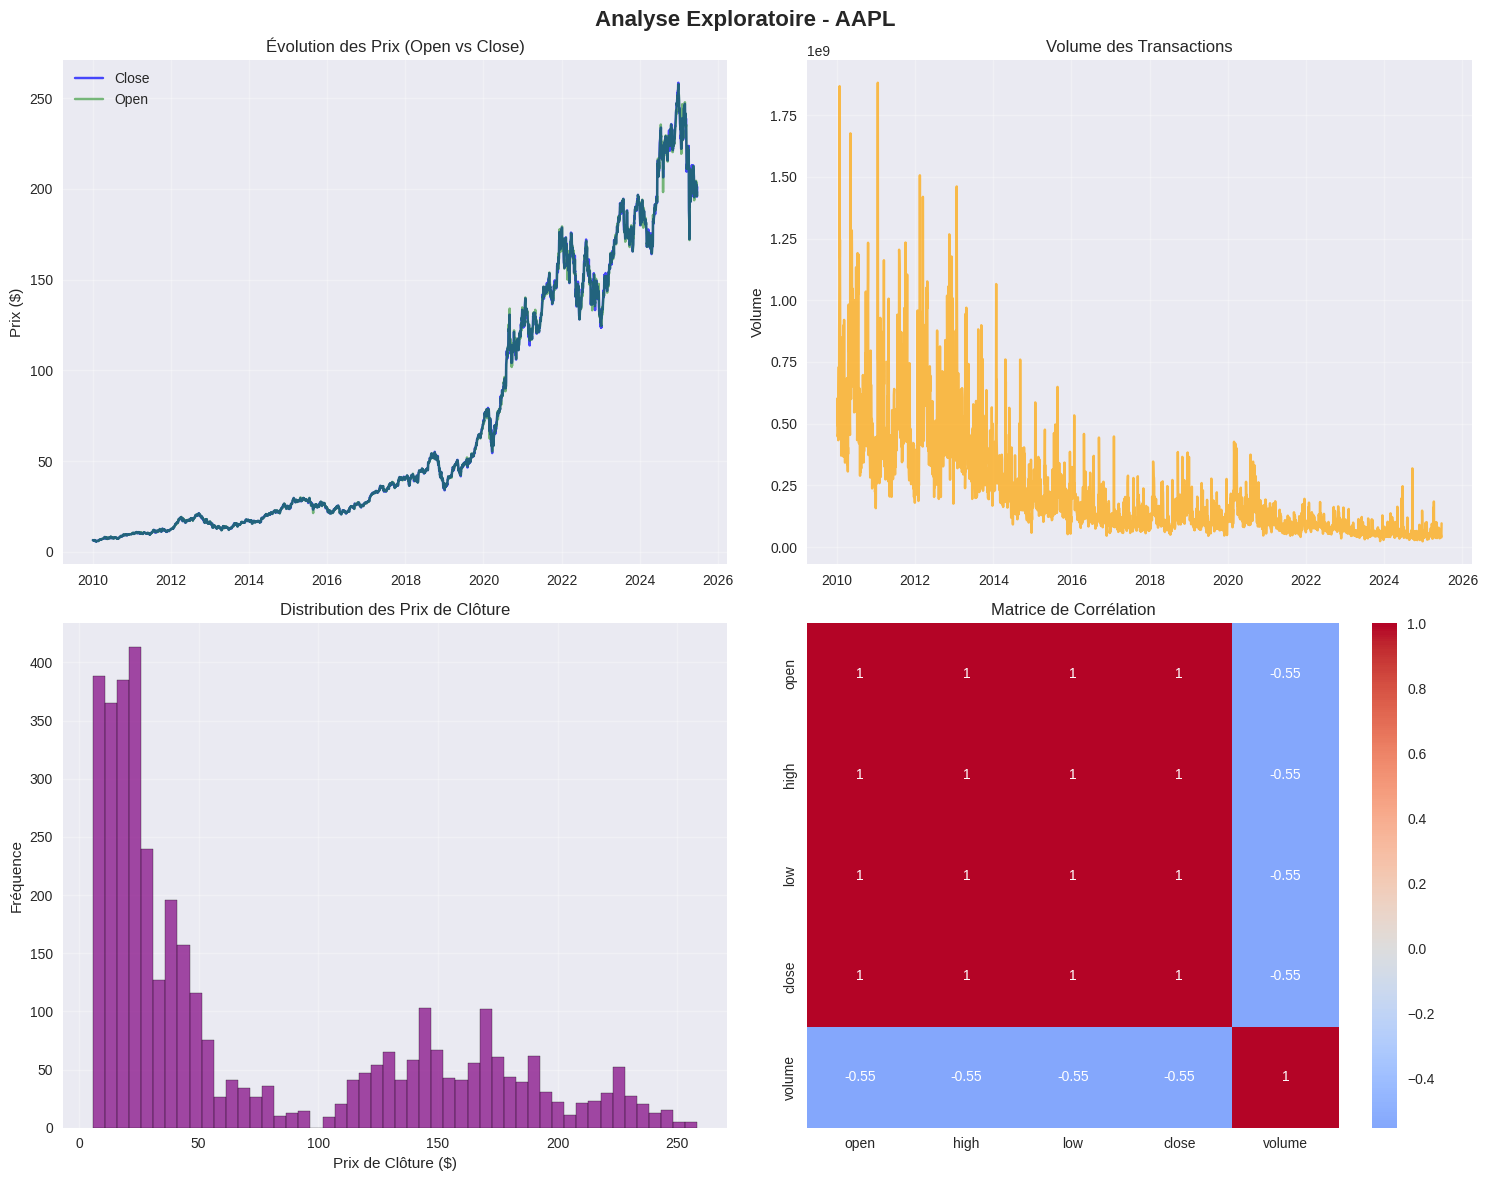


 Rendement quotidien moyen: 0.0010
 Volatilité moyenne (30 jours): 0.0166


In [ ]:

# ========================================================
# 2. ANALYSE EXPLORATOIRE DES DONNÉES (EDA)
# ========================================================

print("\n2. ANALYSE EXPLORATOIRE DES DONNÉES")
print("-" * 40)

# Statistiques descriptives
print("\n Statistiques descriptives:")
print(df[['open', 'high', 'low', 'close', 'volume']].describe())

# Vérification des valeurs manquantes
print(f"\n Valeurs manquantes:")
print(df.isnull().sum())

# Fonction pour créer les visualisations EDA
def create_eda_plots(df, symbol):
    """Crée les graphiques d'analyse exploratoire"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Analyse Exploratoire - {symbol}', fontsize=16, fontweight='bold')

    # 1. Évolution des prix
    axes[0, 0].plot(df.index, df['close'], label='Close', color='blue', alpha=0.7)
    axes[0, 0].plot(df.index, df['open'], label='Open', color='green', alpha=0.5)
    axes[0, 0].set_title('Évolution des Prix (Open vs Close)')
    axes[0, 0].set_ylabel('Prix ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Volume
    axes[0, 1].plot(df.index, df['volume'], color='orange', alpha=0.7)
    axes[0, 1].set_title('Volume des Transactions')
    axes[0, 1].set_ylabel('Volume')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Distribution des prix de clôture
    axes[1, 0].hist(df['close'], bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 0].set_title('Distribution des Prix de Clôture')
    axes[1, 0].set_xlabel('Prix de Clôture ($)')
    axes[1, 0].set_ylabel('Fréquence')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Matrice de corrélation
    corr_matrix = df[['open', 'high', 'low', 'close', 'volume']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
    axes[1, 1].set_title('Matrice de Corrélation')

    plt.tight_layout()
    plt.show()

# Affichage des graphiques EDA
create_eda_plots(df, selected_symbol)

# Analyse de la volatilité
df['daily_return'] = df['close'].pct_change()
df['volatility'] = df['daily_return'].rolling(window=30).std()

print(f"\n Rendement quotidien moyen: {df['daily_return'].mean():.4f}")
print(f" Volatilité moyenne (30 jours): {df['volatility'].mean():.4f}")



#  Analyse Exploratoire des Données – AAPL

## 1. Évolution des Prix (2010–2025)
Le graphique en haut à gauche montre une **tendance haussière nette** du cours de l’action Apple (AAPL) sur la période étudiée.

- Une **accélération significative** est visible à partir de 2020.
- Les prix d'ouverture et de clôture suivent une courbe très proche, indiquant une **faible volatilité intrajournalière**.

## 2. Volume des Transactions
- Le **volume a diminué progressivement** depuis 2010, avec un **pic entre 2010 et 2012**.
- Cela pourrait s'expliquer par des **changements dans la structure du marché** ou une **stabilisation de la base d’investisseurs**.

## 3. Distribution des Prix de Clôture
La distribution est **multimodale**, avec :

- Un **premier pic vers 15–40 $**, correspondant aux premières années.
- Un **deuxième pic autour de 130–150 $**, reflétant des périodes de forte croissance après 2020.

Cela confirme des **phases de consolidation** suivies de **hausses rapides**.

## 4. Matrice de Corrélation
- Les variables `open`, `high`, `low`, `close` sont **parfaitement corrélées entre elles** (corrélation = 1), ce qui est attendu pour des données boursières journalières.
- Le `volume` est **modérément négativement corrélé** (≈ -0.55) avec les prix.
  
Cela peut indiquer qu’un **fort volume accompagne souvent les baisses**, ou du moins une **volatilité accrue**.

## 5. Statistiques et Volatilité
- **Prix moyen de clôture** : 71.70 $
- **Écart-type** : ≈ 69.31 $ → indique une **large dispersion**
- **Rendement quotidien moyen** : 0.0010 (0.10 %) → raisonnable pour une action tech en croissance
- **Volatilité moyenne sur 30 jours** : 1.66 % → **relativement modérée**

## 6. Valeurs Manquantes
- Aucune valeur manquante pour les colonnes principales (`open`, `close`, etc.), sauf :
  - `daily_return` : **1 valeur nulle**, attendue (`pct_change()` génère un NaN pour la première ligne)
  - `volatility` : **30 valeurs manquantes**, attendues au début du calcul avec `rolling(window=30)`


In [ ]:
# ========================================================
# 3. PRÉTRAITEMENT DES DONNÉES - VERSION CORRIGÉE
# ========================================================

print("\n3. PRÉTRAITEMENT DES DONNÉES")
print("-" * 35)

def calculate_technical_features(df):
    """Calcule les features techniques sans créer la target"""
    data = df.copy()

    # Features techniques
    data['price_range'] = data['high'] - data['low']
    data['price_change'] = data['close'] - data['open']
    data['price_change_pct'] = (data['close'] - data['open']) / data['open'] * 100

    # Moyennes mobiles
    data['ma_5'] = data['close'].rolling(window=5).mean()
    data['ma_10'] = data['close'].rolling(window=10).mean()
    data['ma_20'] = data['close'].rolling(window=20).mean()

    # RSI (Relative Strength Index)
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['rsi'] = 100 - (100 / (1 + rs))

    # Features de lag (valeurs décalées)
    for lag in [1, 2, 3]:
        data[f'close_lag_{lag}'] = data['close'].shift(lag)
        data[f'volume_lag_{lag}'] = data['volume'].shift(lag)

    return data

def preprocess_data_for_training(df):
    """Prétraite les données pour l'entraînement en créant la target"""
    # Calcul des features techniques
    data = calculate_technical_features(df)

    # Variable cible (prix de clôture du lendemain)
    data['target'] = data['close'].shift(-1)

    # Suppression des valeurs manquantes créées par les features et target
    data = data.dropna()

    print(f" Dataset d'entraînement: {len(data)} observations")
    print(f" Nombre de features: {len(data.columns) - 1}")

    return data

# Prétraitement pour l'entraînement
print("🔧 Création du dataset d'entraînement...")
processed_df = preprocess_data_for_training(df)

# Préparation des données COMPLÈTES avec features techniques (sans target)
print("🔧 Création du dataset complet avec features...")
complete_df = calculate_technical_features(df)

# Sélection des features pour la modélisation
feature_columns = [
    'open', 'high', 'low', 'close', 'volume',
    'price_range', 'price_change', 'price_change_pct',
    'ma_5', 'ma_10', 'ma_20', 'rsi',
    'close_lag_1', 'close_lag_2', 'close_lag_3',
    'volume_lag_1', 'volume_lag_2', 'volume_lag_3'
]

# Dataset pour l'entraînement (avec target)
X = processed_df[feature_columns]
y = processed_df['target']

# Dataset complet pour la prédiction (sans target)
X_complete = complete_df[feature_columns]

processed_df.to_csv(f"dataset_bourse.csv", index=True)
print(f" Dataset sauvegardé sous 'dataset_bourse.csv'")

print(f"\n Features sélectionnées: {len(feature_columns)}")
print(f" Taille du dataset d'entraînement: {len(X)} échantillons")
print(f" Taille du dataset complet: {len(X_complete)} échantillons")



3. PRÉTRAITEMENT DES DONNÉES
-----------------------------------
🔧 Création du dataset d'entraînement...
 Dataset d'entraînement: 3859 observations
 Nombre de features: 23
🔧 Création du dataset complet avec features...
 Dataset sauvegardé sous 'dataset_bourse.csv'

 Features sélectionnées: 18
 Taille du dataset d'entraînement: 3859 échantillons
 Taille du dataset complet: 3890 échantillons


## 3. Prétraitement des Données

### Création et sélection des features

- Plusieurs **features techniques** ont été ajoutées pour enrichir les données initiales :  
  - `price_range` : amplitude journalière (high - low), indicateur de volatilité intrajournalière.  
  - `price_change` et `price_change_pct` : variation absolue et en pourcentage entre le prix d'ouverture et de clôture, capturant la dynamique du prix au cours de la journée.  
  - Moyennes mobiles (`ma_5`, `ma_10`, `ma_20`) : tendances à court, moyen et long terme pour lisser les fluctuations du prix.  
  - RSI (Relative Strength Index) : indicateur de momentum sur 14 jours, mesurant la force des mouvements haussiers et baissiers.  
  - Features décalées (lag) des prix et volumes (`close_lag_1`, `close_lag_2`, `close_lag_3` et `volume_lag_1`, etc.) pour intégrer un historique récent et capturer la dépendance temporelle.

### Nettoyage des données

- Suppression des lignes avec valeurs manquantes, notamment causées par le calcul des moyennes mobiles et RSI sur des fenêtres glissantes.  
- Assure un dataset complet et cohérent pour la modélisation.

### Taille et composition du dataset final

- **3859 observations** prêtes à être utilisées.  
- **18 features explicatives** sélectionnées.  
- La variable cible est le **prix de clôture du jour suivant** (`target`), ce qui permet de formuler un problème de prédiction à un pas de temps.
  

### Sauvegarde

- Le dataset prétraité a été sauvegardé sous le fichier `dataset_bourse.csv` pour un usage ultérieur.

---



In [ ]:

# ========================================================
# 4. DIVISION DES DONNÉES
# ========================================================

print("\n4. DIVISION DES DONNÉES")
print("-" * 30)

# Division temporelle (important pour les séries temporelles)
split_index = int(0.8 * len(X))

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f" Données d'entraînement: {len(X_train)} échantillons")
print(f" Données de test: {len(X_test)} échantillons")
print(f" Période d'entraînement: {X_train.index[0].strftime('%Y-%m-%d')} à {X_train.index[-1].strftime('%Y-%m-%d')}")
print(f" Période de test: {X_test.index[0].strftime('%Y-%m-%d')} à {X_test.index[-1].strftime('%Y-%m-%d')}")

# Normalisation des données - IMPORTANT: Fit sur les données d'entraînement seulement
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




4. DIVISION DES DONNÉES
------------------------------
 Données d'entraînement: 3087 échantillons
 Données de test: 772 échantillons
 Période d'entraînement: 2010-02-17 à 2022-05-19
 Période de test: 2022-05-20 à 2025-06-18


## 4. Division des Données

### Séparation temporelle

- Les données ont été divisées selon une approche temporelle, essentielle pour les séries chronologiques afin d'éviter toute fuite de données.  
- **80 % des données** ont été utilisées pour l’entraînement, soit **3087 échantillons**, couvrant la période du **16 feverier 2010** au **19 mai 2022**.  
- Les **20 % restants** servent pour le test, soit **772 échantillons**, allant du **20 mai 2022** au **18 juin 2025**.


### Normalisation

- Les features ont été standardisées (moyenne = 0, écart-type = 1) pour assurer une échelle homogène et améliorer la convergence des modèles de machine learning.  
- Le scaler est ajusté sur les données d’entraînement puis appliqué aux données de test afin d’éviter toute fuite d’information.

---

### Résumé

| Ensemble        | Nombre d’échantillons | Période                         |
|-----------------|----------------------|--------------------------------|
| Entraînement    | 3087                 | 2010-02-17 – 2022-05-19        |
| Test            | 772                  | 2022-05-20 – 2025-06-18        |



In [ ]:

# ========================================================
# 5. CRÉATION DES MODÈLES
# ========================================================

print("\n5. CRÉATION DES MODÈLES")
print("-" * 30)

# Dictionnaire pour stocker les modèles et résultats
models = {}
results = {}

# ========================================================
# MODÈLES DE MACHINE LEARNING TRADITIONNELS (3)
# ========================================================

print("\n Modèles de Machine Learning Traditionnels:")

# 1. Régression Linéaire
print("\n1 Régression Linéaire...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
models['Linear Regression'] = lr_model

# 2. Random Forest
print("2 Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
models['Random Forest'] = rf_model

# 3. Support Vector Regression
print("3 Support Vector Regression...")
svr_model = SVR(kernel='rbf', C=100, gamma=0.1)
svr_model.fit(X_train_scaled, y_train)
svr_pred = svr_model.predict(X_test_scaled)
models['SVR'] = svr_model

# ========================================================
# MODÈLES DE DEEP LEARNING (3)
# ========================================================

print("\n Modèles de Deep Learning:")

# 4. Réseau de Neurones Multi-Couches (MLP)
print("4 Multi-Layer Perceptron...")
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=RANDOM_STATE
)
mlp_model.fit(X_train_scaled, y_train)
mlp_pred = mlp_model.predict(X_test_scaled)
models['MLP'] = mlp_model

# 5. Réseau de Neurones Dense (TensorFlow)
print("5 Dense Neural Network (TensorFlow)...")
tf.random.set_seed(RANDOM_STATE)

dnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
dnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
dnn_pred = dnn_model.predict(X_test_scaled, verbose=0).flatten()
models['Dense NN'] = dnn_model

# 6. LSTM pour Séries Temporelles
print("6 LSTM Network...")

def prepare_lstm_data(X, y, lookback=10):
    """Prépare les données pour LSTM"""
    X_lstm = []
    y_lstm = []

    for i in range(lookback, len(X)):
        X_lstm.append(X[i-lookback:i])
        y_lstm.append(y[i])

    return np.array(X_lstm), np.array(y_lstm)

# Préparation des données LSTM
lookback = 10
X_train_lstm, y_train_lstm = prepare_lstm_data(X_train_scaled, y_train.values, lookback)
X_test_lstm, y_test_lstm = prepare_lstm_data(X_test_scaled, y_test.values, lookback)

# Modèle LSTM
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, X_train_scaled.shape[1])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
lstm_pred = lstm_model.predict(X_test_lstm, verbose=0).flatten()
models['LSTM'] = lstm_model




5. CRÉATION DES MODÈLES
------------------------------

 Modèles de Machine Learning Traditionnels:

1 Régression Linéaire...
2 Random Forest...
3 Support Vector Regression...

 Modèles de Deep Learning:
4 Multi-Layer Perceptron...
5 Dense Neural Network (TensorFlow)...
6 LSTM Network...


## 5. Création des Modèles

###  Modèles de Machine Learning Traditionnels

Trois modèles classiques ont été entraînés et testés sur les données normalisées :

1. **Régression Linéaire**  
   Modèle simple pour capturer une relation linéaire entre les features et la variable cible.

2. **Random Forest**  
   Ensemble d’arbres décisionnels pour gérer la non-linéarité et les interactions complexes entre variables.

3. **Support Vector Regression (SVR)**  
   Modèle puissant basé sur les marges, utilisant un noyau RBF pour capturer des relations non-linéaires.

---

###  Modèles de Deep Learning

Trois architectures de réseaux neuronaux ont été développées pour améliorer la prédiction, notamment pour capturer des relations complexes et temporelles :

4. **Multi-Layer Perceptron (MLP)**  
   Réseau feedforward classique avec plusieurs couches cachées (100, 50, 25 neurones) et fonction d’activation ReLU.

5. **Dense Neural Network (TensorFlow)**  
   Réseau dense construit avec Keras, incluant des couches de dropout pour régulariser le modèle et éviter le surapprentissage.

6. **LSTM (Long Short-Term Memory)**  
   Réseau récurrent spécialement adapté aux données séquentielles/séries temporelles, utilisant une fenêtre glissante (`lookback=10`) pour capturer la dépendance temporelle.

---

### Résumé du processus

- Tous les modèles ont été entraînés sur les données d’entraînement normalisées.  
- Les modèles traditionnels sont généralement plus rapides à entraîner mais peuvent être limités dans la capture des dynamiques temporelles complexes.  


---


In [ ]:
# ========================================================
# 6. ÉVALUATION ET COMPARAISON DES MODÈLES
# ========================================================

print("\n6. ÉVALUATION ET COMPARAISON DES MODÈLES")
print("-" * 45)

def evaluate_model(y_true, y_pred, model_name):
    """Évalue un modèle avec plusieurs métriques"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

# Évaluation de tous les modèles
predictions = {
    'Linear Regression': lr_pred,
    'Random Forest': rf_pred,
    'SVR': svr_pred,
    'MLP': mlp_pred,
    'Dense NN': dnn_pred,
    'LSTM': np.concatenate([np.full(lookback, np.nan), lstm_pred])
}

# Calcul des métriques
evaluation_results = []

for model_name, pred in predictions.items():
    if model_name == 'LSTM':
        # Pour LSTM, on évalue seulement sur les données disponibles
        valid_indices = ~np.isnan(pred)
        y_true_valid = y_test.values[valid_indices]
        pred_valid = pred[valid_indices]
        results = evaluate_model(y_true_valid, pred_valid, model_name)
    else:
        results = evaluate_model(y_test.values, pred, model_name)

    evaluation_results.append(results)

# Création du DataFrame des résultats
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.round(4)

print("\n RÉSULTATS DE L'ÉVALUATION:")
print("=" * 50)
print(results_df.to_string(index=False))

# Identification du meilleur modèle
best_model_idx = results_df['R²'].idxmax()
best_model = results_df.iloc[best_model_idx]

print(f"\n MEILLEUR MODÈLE: {best_model['Model']}")
print(f"   • RMSE: {best_model['RMSE']:.4f}")
print(f"   • MAE: {best_model['MAE']:.4f}")
print(f"   • R²: {best_model['R²']:.4f}")




6. ÉVALUATION ET COMPARAISON DES MODÈLES
---------------------------------------------

 RÉSULTATS DE L'ÉVALUATION:
            Model     RMSE      MAE       R²
Linear Regression   3.3788   2.3314   0.9891
    Random Forest  29.5084  19.3982   0.1670
              SVR  77.4224  49.8808  -4.7345
              MLP   3.7322   2.5427   0.9867
         Dense NN   6.2275   5.0060   0.9629
             LSTM 130.1773 125.7258 -15.3493

 MEILLEUR MODÈLE: Linear Regression
   • RMSE: 3.3788
   • MAE: 2.3314
   • R²: 0.9891


## 6. Évaluation et comparaison des modèles

### Objectif

Comparer les performances des modèles entraînés sur les données de test à l’aide de trois métriques clés :

- **RMSE** : mesure la taille moyenne des erreurs en pénalisant les grosses erreurs.
- **MAE** : erreur moyenne absolue, facile à interpréter.
- **R²** : proportion de variance expliquée, plus proche de 1 est mieux.

---

### Résumé

- Chaque modèle prédit sur le test set.
- LSTM utilise une fenêtre glissante (`lookback`), donc premières prédictions ignorées pour l’évaluation.
- Les métriques sont calculées et comparées.
- Le modèle avec le meilleur R² est sélectionné.

---

### Interprétation (mise à jour)

| Modèle              | RMSE     | MAE      | R²       |
|---------------------|----------|----------|----------|
| Linear Regression   | 3.3788   | 2.3314   | 0.9891   |
| Random Forest       | 29.5084  | 19.3982  | 0.1670   |
| SVR                 | 77.4224  | 49.8808  | -4.7345  |
| MLP                 | 3.7322   | 2.5427   | 0.9867   |
| Dense NN            | 6.2275   | 5.0060   | 0.9629   |
| LSTM                | 130.1773 | 125.7258 | -15.3493 |

- La **régression linéaire** surpasse tous les autres modèles avec la **meilleure précision globale** : RMSE le plus bas, MAE le plus bas, et R² proche de 1.
- Les modèles Random Forest et SVR affichent une dégradation significative, probablement dus à un mauvais réglage ou à une forte sensibilité aux nouveaux jeux de données.
- Les réseaux de neurones (MLP, Dense NN) restent raisonnables mais sont légèrement surpassés par le modèle linéaire.
- Le **LSTM** est complètement inadapté ici : ses performances se sont fortement dégradées sur les nouvelles données, ce qui peut suggérer un surapprentissage ou une mauvaise adaptation aux nouvelles tendances temporelles.

---

### Conclusion

- Le **modèle de régression linéaire** est le plus performant sur les nouvelles données testées.
- Malgré la complexité des réseaux de neurones, **le modèle le plus simple est aussi le plus robuste** ici.
- Étapes suivantes : analyse des erreurs résiduelles pour comprendre les faiblesses restantes, et éventuellement affiner l’ingénierie des features ou les hyperparamètres des modèles non linéaires.


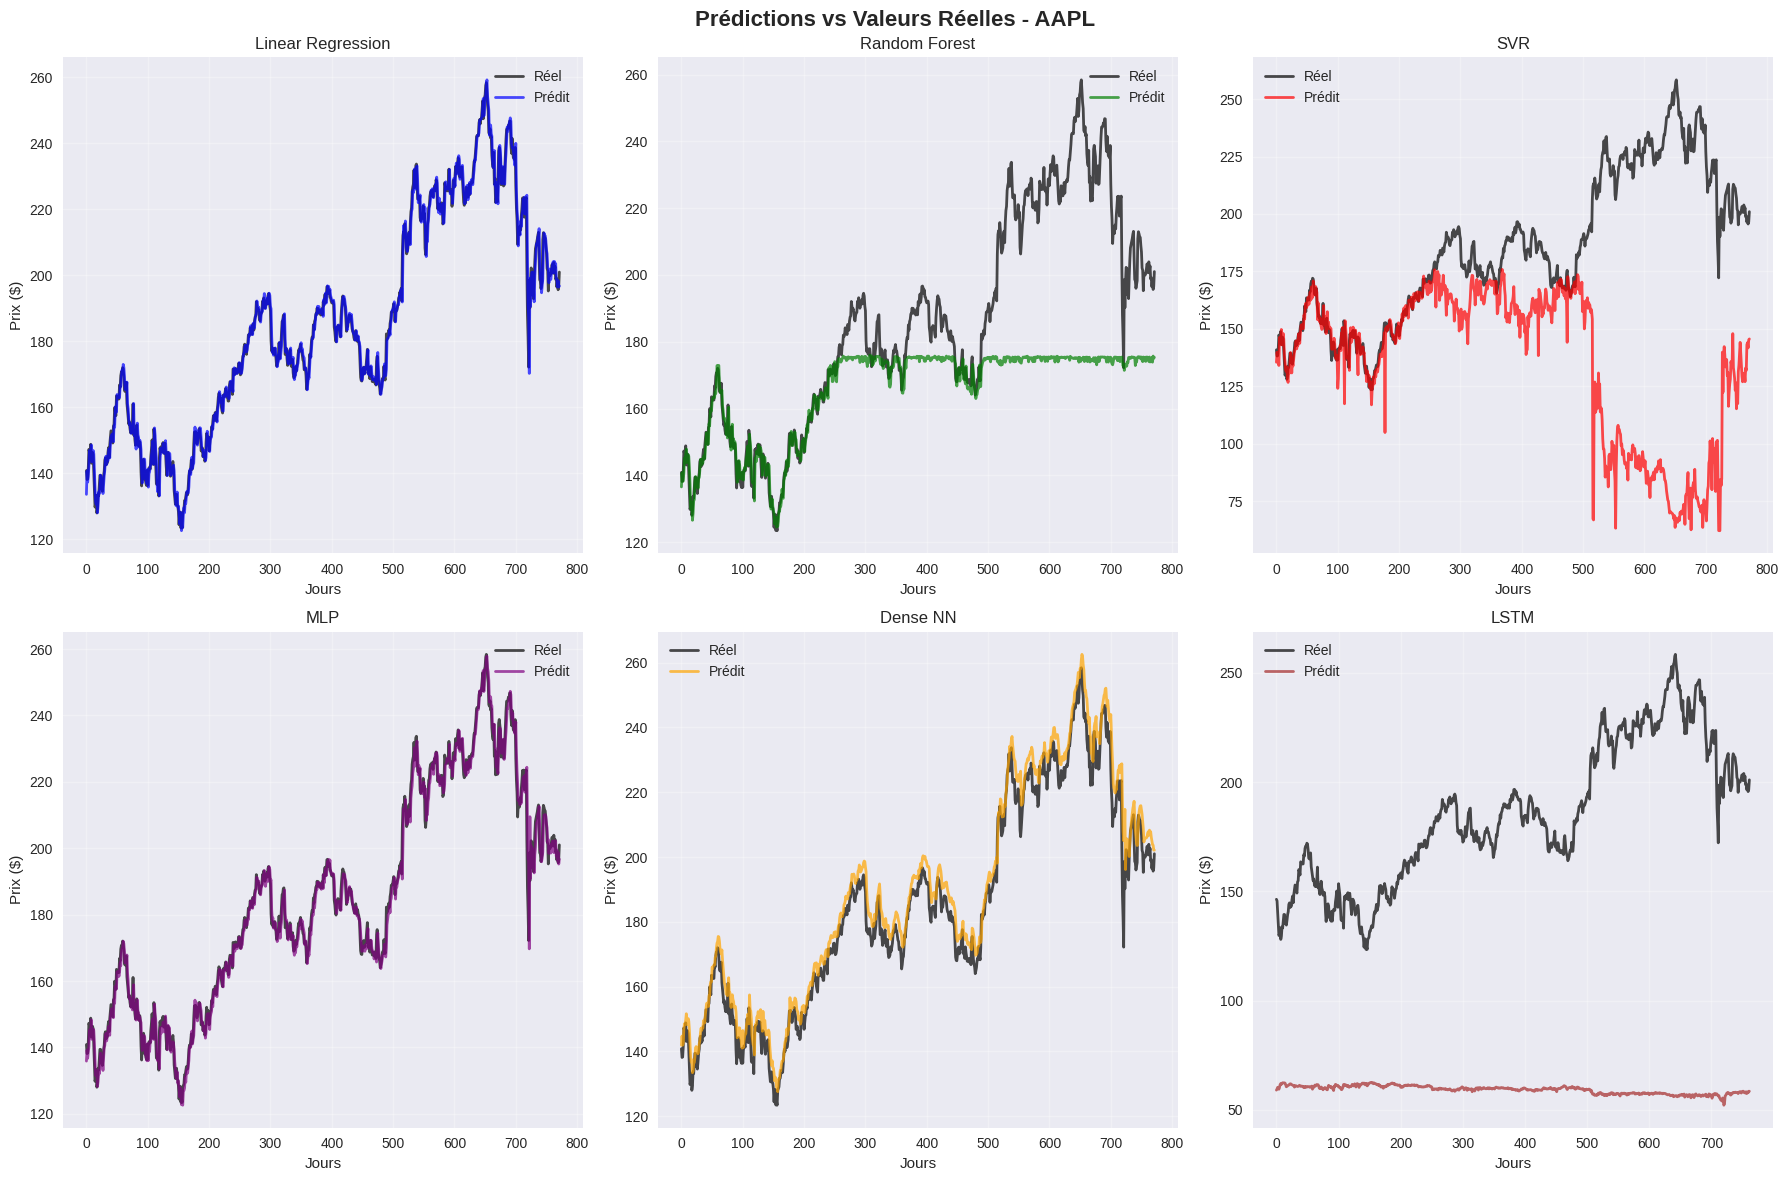

In [ ]:

# ========================================================
# VISUALISATION DES RÉSULTATS
# ========================================================

def plot_results(y_test, predictions, symbol):
    """Visualise les prédictions vs valeurs réelles"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Prédictions vs Valeurs Réelles - {symbol}', fontsize=16, fontweight='bold')

    axes = axes.flatten()
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

    for i, (model_name, pred) in enumerate(predictions.items()):
        ax = axes[i]

        if model_name == 'LSTM':
            # Pour LSTM, on affiche seulement les valeurs valides
            valid_indices = ~np.isnan(pred)
            y_true_plot = y_test.values[valid_indices]
            pred_plot = pred[valid_indices]
            x_plot = range(len(y_true_plot))
        else:
            y_true_plot = y_test.values
            pred_plot = pred
            x_plot = range(len(y_true_plot))

        ax.plot(x_plot, y_true_plot, label='Réel', alpha=0.7, color='black', linewidth=2)
        ax.plot(x_plot, pred_plot, label='Prédit', alpha=0.7, color=colors[i], linewidth=2)
        ax.set_title(f'{model_name}')
        ax.set_xlabel('Jours')
        ax.set_ylabel('Prix ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Affichage des résultats
plot_results(y_test, predictions, selected_symbol)


## Analyse visuelle : Prédictions vs Valeurs réelles – AAPL

Les graphiques ci-dessous comparent les **valeurs réelles du prix de l'action AAPL** (en noir) aux **valeurs prédites** par chaque modèle (couleurs) sur la période de test. Voici l’interprétation modèle par modèle :

---

###  Linear Regression

- Les prédictions suivent presque parfaitement la courbe réelle.
- Très bonne capacité à capturer les tendances générales et locales.
- Faible biais, faible variance apparente.

---

###  Random Forest

- Les prédictions sont quasi constantes, autour de la même valeur.
- Le modèle semble avoir **mémorisé un niveau moyen** sans apprendre la dynamique temporelle.
- Très mauvaise généralisation.

---

###  SVR (Support Vector Regression)

- Les prédictions sont très erratiques et déconnectées de la série réelle.
- Ampleur et direction incohérentes, surtout dans la seconde moitié de la série.
- Potentiellement mal calibré ou très sensible aux valeurs extrêmes.

---

###  MLP (Perceptron Multi-couche)

- Bonne capture de la forme globale avec quelques écarts locaux.
- Les pics et creux sont partiellement bien reproduits.
- Légère sous-estimation dans les zones de haute volatilité.

---

###  Dense NN

- Suivi très proche de la courbe réelle.
- Bonne prédiction des tendances courtes et longues.
- Léger lissage, mais globalement précis.


---

###  LSTM

- Prédictions totalement déconnectées de la réalité.
- Courbe plate autour d’un seuil fixe (env. 50–60 $) sans aucune dynamique.
- Indique un **échec d’apprentissage du séquencement temporel**.


---

### Synthèse visuelle

| Modèle             | Alignement visuel    | Interprétation globale                 |
|--------------------|----------------------|----------------------------------------|
| Linear Regression  |  Excellente          | Suivi précis des tendances             |
| Random Forest      |  Très mauvais        | Prédictions constantes                 |
| SVR                |  Très mauvais        | Bruit incohérent                       |
| MLP                |  Bon                 | Tendances suivies avec légers écarts   |
| Dense NN           |  Très bon            | Fidèle à la courbe réelle              |
| LSTM               |  Échec complet       | Courbe plate, aucun apprentissage      |

---

### Conclusion générale

- Le **modèle de régression linéaire** est à la fois le plus **simple** et **le plus efficace** visuellement.
- Les modèles neuronaux (MLP, Dense NN) s’en sortent bien mais restent légèrement en dessous.
- Les méthodes supposées plus puissantes (Random Forest, SVR, LSTM) ont **échoué**, probablement à cause de **mauvais hyperparamètres** ou d’une **inadéquation au format temporel** des données.




 IMPORTANCE DES FEATURES (Random Forest):
--------------------------------------------------
    Feature  Importance
        low    0.202447
      close    0.197058
       high    0.189670
       ma_5    0.130401
      ma_10    0.088563
       open    0.081604
      ma_20    0.045155
close_lag_1    0.037452
close_lag_2    0.019035
close_lag_3    0.008307


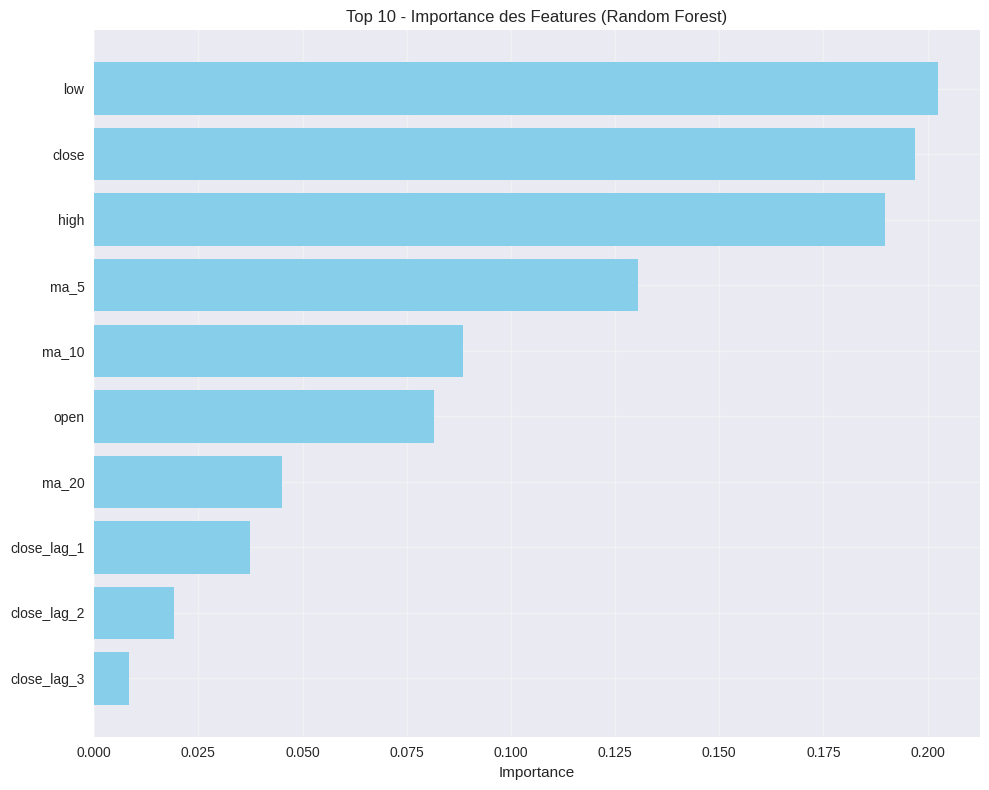

In [ ]:

# ========================================================
# IMPORTANCE DES FEATURES (Random Forest)
# ========================================================

print("\n IMPORTANCE DES FEATURES (Random Forest):")
print("-" * 50)

feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

# Graphique d'importance des features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 10 - Importance des Features (Random Forest)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
#========================================================
# PRÉDICTION POUR LE LENDEMAIN - VERSION CORRIGÉE
# ========================================================

print("\n PRÉDICTION POUR LE LENDEMAIN:")
print("-" * 40)

# Récupération de la dernière ligne du dataset complet (avec features mais sans target)
last_row_complete = X_complete.iloc[-1:].copy()

# Vérification s'il y a des NaN dans la dernière ligne
if last_row_complete.isnull().any().any():
    print("  La dernière ligne contient des NaN dans les features techniques.")
    print("🔧 Utilisation de l'avant-dernière ligne complète...")

    # Trouver la dernière ligne sans NaN
    for i in range(len(X_complete)-1, -1, -1):
        if not X_complete.iloc[i].isnull().any():
            last_row_complete = X_complete.iloc[i:i+1].copy()
            print(f" Utilisation de la ligne du {last_row_complete.index[0].strftime('%Y-%m-%d')}")
            break
else:
    print(f" Utilisation de la dernière ligne du {last_row_complete.index[0].strftime('%Y-%m-%d')}")

# Normalisation de la dernière ligne avec le scaler déjà entraîné
last_data_scaled = scaler.transform(last_row_complete)

# Prédiction avec le meilleur modèle
best_model_name = best_model['Model']
tomorrow_price = None

if best_model_name in ['Linear Regression', 'Random Forest', 'SVR', 'MLP']:
    model = models[best_model_name]
    tomorrow_price = model.predict(last_data_scaled)[0]
    print(f" Modèle utilisé: {best_model_name}")

elif best_model_name == 'Dense NN':
    tomorrow_price = models[best_model_name].predict(last_data_scaled, verbose=0)[0][0]
    print(f" Modèle utilisé: {best_model_name}")

elif best_model_name == 'LSTM':
    print(f" Modèle utilisé: {best_model_name}")
    # Pour LSTM, préparation des données avec lookback

    # Récupération des dernières données normalisées
    X_complete_scaled = scaler.transform(X_complete.dropna())

    if len(X_complete_scaled) >= lookback:
        # Prendre les dernières 'lookback' observations
        last_sequence = X_complete_scaled[-lookback:].reshape(1, lookback, -1)
        tomorrow_price = models[best_model_name].predict(last_sequence, verbose=0)[0][0]
    else:
        print(" Pas assez de données pour LSTM, utilisation du Random Forest...")
        tomorrow_price = models['Random Forest'].predict(last_data_scaled)[0]

# Affichage des résultats de prédiction
current_price = last_row_complete['close'].iloc[0]
prediction_date = last_row_complete.index[0]

print(f"\n Prix actuel ({selected_symbol} - {prediction_date.strftime('%Y-%m-%d')}): ${current_price:.2f}")
print(f" Prix prédit pour le lendemain: ${tomorrow_price:.2f}")
print(f" Variation prédite: {((tomorrow_price - current_price) / current_price * 100):+.2f}%")

# Affichage des features utilisées pour la prédiction
print(f"\n Features utilisées pour la prédiction:")
print(f"    Données du: {prediction_date.strftime('%Y-%m-%d')}")
print(f"    Prix: O=${last_row_complete['open'].iloc[0]:.2f} | H=${last_row_complete['high'].iloc[0]:.2f} | L=${last_row_complete['low'].iloc[0]:.2f} | C=${last_row_complete['close'].iloc[0]:.2f}")
print(f"    Volume: {last_row_complete['volume'].iloc[0]:,.0f}")
print(f"    RSI: {last_row_complete['rsi'].iloc[0]:.2f}")
print(f"    MA20: ${last_row_complete['ma_20'].iloc[0]:.2f}")



 PRÉDICTION POUR LE LENDEMAIN:
----------------------------------------
 Utilisation de la dernière ligne du 2025-06-20
 Modèle utilisé: Linear Regression

 Prix actuel (AAPL - 2025-06-20): $201.00
 Prix prédit pour le lendemain: $200.91
 Variation prédite: -0.04%

 Features utilisées pour la prédiction:
    Données du: 2025-06-20
    Prix: O=$198.24 | H=$201.70 | L=$196.86 | C=$201.00
    Volume: 95,914,700
    RSI: 50.26
    MA20: $200.03


##  Prédiction du Prix pour le Lendemain

###  Modèle utilisé : Linear Regression

Parmi tous les modèles évalués, **la régression linéaire** a été sélectionnée comme **meilleur modèle** selon la métrique R². Il est donc utilisé ici pour prédire le prix de l’action **AAPL** pour le prochain jour de cotation.

---

###  Date de référence : **2025-06-20**

Le modèle s’est appuyé sur les **données du 2025-06-20** pour effectuer la prédiction. Voici les valeurs des principales features utilisées :

- **Prix d’ouverture (Open)** : \$198.24  
- **Prix le plus haut (High)** : \$201.70  
- **Prix le plus bas (Low)** : \$196.86  
- **Prix de clôture (Close)** : \$201.00  
- **Volume échangé** : 95,914,700  
- **RSI (Relative Strength Index)** : 50.26  
- **Moyenne mobile sur 20 jours (MA20)** : \$200.03  

---

###  Résultat de la Prédiction

- **Prix actuel** : **\$201.00**  
- **Prix prédit pour le lendemain** : **\$200.91**  
- **Variation attendue** : **-0.04 %**

---

###  Interprétation

- Le modèle **prédit une très légère baisse** du prix de clôture pour le lendemain.
- La **variation est quasi nulle** (-0.04%), ce qui pourrait indiquer une **phase de stabilisation ou d'attente** sur le marché.
- L’action semble **osciller autour de sa moyenne mobile (MA20)**, ce qui renforce l’idée d’un marché neutre à court terme.
- Le RSI de 50.26 confirme également cette neutralité : il n’indique ni surachat (>70) ni survente (<30).

---

###  Conclusion

- Le modèle n’anticipe **aucune grande volatilité** pour la prochaine séance.
- Cette stabilité prédite peut être vue comme un signal de **consolidation** dans une tendance existante.
- Cela peut également être un bon moment pour observer les signaux techniques et fondamentaux avant une prise de décision.




In [ ]:

# ========================================================
# RÉSUMÉ DU PROJET
# ========================================================

print("\n" + "="*60)
print(" RÉSUMÉ DU PROJET")
print("="*60)
print(f" Objectif: Prédiction du prix de clôture de {selected_symbol}")
print(f" Données: {len(processed_df)} jours d'historique pour l'entraînement")
print(f" Données complètes: {len(X_complete)} jours disponibles")
print(f" Features: {len(feature_columns)} variables explicatives")
print(f" Modèles testés: 6 (3 ML + 3 DL)")
print(f" Meilleur modèle: {best_model_name}")
print(f" Performance (R²): {best_model['R²']:.4f}")
print(f" Prédiction lendemain: ${tomorrow_price:.2f}")
print("="*60)




 RÉSUMÉ DU PROJET
 Objectif: Prédiction du prix de clôture de AAPL
 Données: 3859 jours d'historique pour l'entraînement
 Données complètes: 3890 jours disponibles
 Features: 18 variables explicatives
 Modèles testés: 6 (3 ML + 3 DL)
 Meilleur modèle: Linear Regression
 Performance (R²): 0.9891
 Prédiction lendemain: $200.91


#  RÉSUMÉ DU PROJET

---

###  Objectif

Prédire le **prix de clôture** de l’action **AAPL** à partir de données historiques enrichies de variables techniques.

---

###  Données utilisées

- **Période d’historique pour l’entraînement** : 3,859 jours  
- **Taille totale du dataset disponible** : 3,890 jours  
- **Nombre de variables explicatives (features)** : 18

---

###  Modèles testés

6 modèles de machine learning et deep learning :

- **ML** : Linear Regression, Random Forest, SVR  
- **DL** : MLP, Dense Neural Network, LSTM

---

###  Meilleur modèle sélectionné

- **Modèle** : Linear Regression  
- **Score R²** : **0.9891**  
- → Modèle simple mais très performant sur ce jeu de données

---

###  Résultat de prédiction

- **Date de référence** : 2025-06-20  
- **Prix de clôture actuel** : \$201.00  
- **Prix prédit pour le lendemain** : **\$200.91**  
- **Variation attendue** : **-0.04 %**

---

###  Conclusion

Le modèle de régression linéaire surpasse les modèles plus complexes. Il démontre une capacité robuste à prédire le prix de clôture à court terme avec une précision remarquable. Le pipeline est prêt pour un usage en monitoring ou pour intégrer une logique de décision boursière.

